                                        Flow_ID           Src_IP  Src_Port  \
0      192.168.100.150-192.168.100.3-51370-80-6  192.168.100.150     51370   
1      192.168.100.150-192.168.100.3-51368-80-6  192.168.100.150     51368   
2      192.168.100.150-192.168.100.3-51372-80-6  192.168.100.150     51372   
3      192.168.100.150-192.168.100.3-51374-80-6  192.168.100.150     51374   
4      192.168.100.150-192.168.100.3-51376-80-6  192.168.100.150     51376   
...                                         ...              ...       ...   
52461         192.168.100.3-192.168.100.5-0-0-6    192.168.100.5         0   
52462   192.168.100.5-192.168.100.46-80-3456-17   192.168.100.46      3456   
52463      192.168.100.5-192.168.100.46-80-80-6   192.168.100.46        80   
52464       192.168.100.3-192.168.100.6-80-80-6    192.168.100.6        80   
52465  192.168.100.3-52.64.239.193-41307-8883-6    192.168.100.3     41307   

              Dst_IP  Dst_Port  Protocol               Timestam

<ipython-input-22-8080f5a83756>:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset4['Label'] = dataset4['Label'].replace({'Normal': 0, 'Anomaly': 1})
<ipython-input-22-8080f5a83756>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset4['Cat'] = dataset4['Cat'].replace({'Normal': 0, 'DoS': 1})


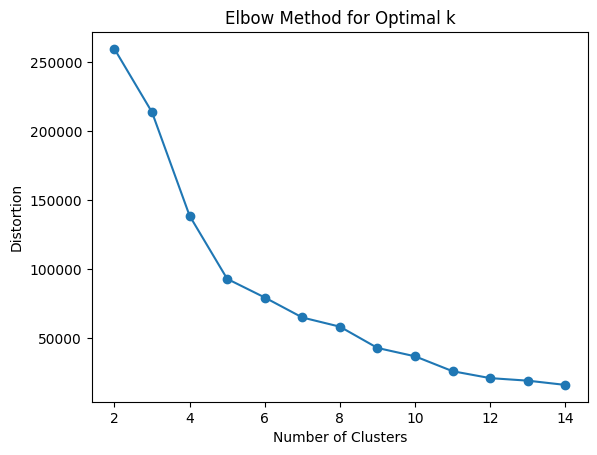

Silhouette Score: 0.715456905900107


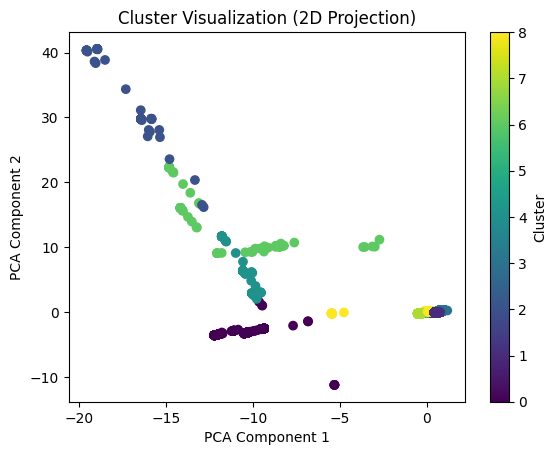

                                        Flow_ID  Src_IP  Src_Port  Dst_IP  \
0      192.168.100.150-192.168.100.3-51370-80-6       4     51370       9   
1      192.168.100.150-192.168.100.3-51368-80-6       4     51368       9   
2      192.168.100.150-192.168.100.3-51372-80-6       4     51372       9   
3      192.168.100.150-192.168.100.3-51374-80-6       4     51374       9   
4      192.168.100.150-192.168.100.3-51376-80-6       4     51376       9   
...                                         ...     ...       ...     ...   
52461         192.168.100.3-192.168.100.5-0-0-6       8         0       9   
52462   192.168.100.5-192.168.100.46-80-3456-17       7      3456      11   
52463      192.168.100.5-192.168.100.46-80-80-6       7        80      11   
52464       192.168.100.3-192.168.100.6-80-80-6      10        80       9   
52465  192.168.100.3-52.64.239.193-41307-8883-6       5     41307      25   

       Dst_Port  Protocol               Timestamp  Flow_Duration  \
0      

In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the dataset
dataset4 = pd.read_csv('Dosattack.csv', on_bad_lines='skip')
print(dataset4)
# Drop rows with missing values (optional: analyze before dropping)
dataset4 = dataset4.dropna()

# Fill missing values
for col in dataset4.columns:
    if dataset4[col].dtype == 'object':  # Categorical
        dataset4[col] = dataset4[col].fillna(dataset4[col].mode()[0])
    else:  # Numerical
        dataset4[col] = dataset4[col].fillna(dataset4[col].mean())
# change the str to int
dataset4['Label'] = dataset4['Label'].replace({'Normal': 0, 'Anomaly': 1})
dataset4['Cat'] = dataset4['Cat'].replace({'Normal': 0, 'DoS': 1})
# Encode categorical features (e.g., Dst_IP, Protocol)
label_encoder = LabelEncoder()
dataset4['Dst_IP'] = label_encoder.fit_transform(dataset4['Dst_IP'])
dataset4['Protocol'] = label_encoder.fit_transform(dataset4['Protocol'])

# Transform Timestamp into hour of day
# dataset4['Hour'] = pd.to_datetime(dataset4['Timestamp']).dt.hour
# dataset4 = dataset4.drop(columns=['Timestamp'])  # Drop raw Timestamp if unnecessary
dataset4['Src_IP'] = label_encoder.fit_transform(dataset4['Src_IP'])
# Select features for clustering
features = ["Dst_IP", "Dst_Port", "Tot_Fwd_Pkts", "Tot_Bwd_Pkts", "Src_IP", "Src_Port", "Protocol", "Label", "Cat"]
data = dataset4[features].copy()


# Scale the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Determine optimal number of clusters using the Elbow Method
distortions = []
k_range = range(2, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    distortions.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(k_range, distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()

# Choose optimal k (based on the elbow point)
optimal_k = 9  # Replace with your chosen k

# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k,n_init=50, random_state=42)
kmeans.fit(data_scaled)

# Add cluster labels to the dataset
dataset4['Cluster'] = kmeans.labels_

# Evaluate cluster quality using Silhouette Score
silhouette_avg = silhouette_score(data_scaled, kmeans.labels_)
print(f'Silhouette Score: {silhouette_avg}')

# Visualize clusters (optional, using PCA for 2D projection)
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
data_2d = pca.fit_transform(data_scaled)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('Cluster Visualization (2D Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()
print(dataset4)

In [ ]:
# Perform PCA for dimensionality reduction
# pca = PCA(n_components=5)  # Retain top 5 components
# data_pca = pca.fit_transform(data_scaled)

# # Test different k values
# for k in range(2, 10):
#     kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
#     labels = kmeans.fit_predict(data_pca)
#     score = silhouette_score(data_pca, labels)
#     print(f"Silhouette Score for k={k}: {score}")

In [ ]:
# @title Training the model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and Labels
features = ["Dst_IP", "Dst_Port", "Tot_Fwd_Pkts", "Tot_Bwd_Pkts", "Src_IP", "Src_Port", "Protocol"]
Labels = ["Label"]
X = dataset4[features]
y = dataset4[Labels]  # Assuming Label is already prepared (0 for normal, 1 for DoS)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(data.Label)

0        1
1        1
2        1
3        1
4        1
        ..
52461    0
52462    0
52463    0
52464    0
52465    0
Name: Label, Length: 52463, dtype: int64


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define MLP model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Modified: Output layer with 2 nodes for 2 target variables
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
mlp_model.fit(X_train, y_train)
y_pred = mlp_model.predict(X_test)

# Evaluate the model
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test, y_test)
print(f"MLP Accuracy: {mlp_accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1312/1312 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9932 - loss: 0.0998
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.0012
MLP Accuracy: 0.9998093843460083


In [ ]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = (mlp_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       1.00      1.00      1.00     10142

    accuracy                           1.00     10493
   macro avg       1.00      1.00      1.00     10493
weighted avg       1.00      1.00      1.00     10493



In [ ]:
dataset4['Label'].value_counts()


,count
Label,
1,50763
0,1700


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = (mlp_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       1.00      1.00      1.00     10142

    accuracy                           1.00     10493
   macro avg       1.00      1.00      1.00     10493
weighted avg       1.00      1.00      1.00     10493



In [ ]:
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test, y_test)
print(f"MLP Accuracy: {mlp_accuracy}")

328/328 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9998 - loss: 0.0012
MLP Accuracy: 0.9998093843460083


In [ ]:
from collections import Counter

print("Class distribution in training set:", Counter(y_train))
print("Class distribution in resampled set:", Counter(y_resampled))


Class distribution in training set: Counter({'Label': 1})
Class distribution in resampled set: Counter({'Label': 1})


confusion metric

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = (mlp_model.predict(X_test) > 0.5).astype("int32")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       1.00      1.00      1.00     10142

    accuracy                           1.00     10493
   macro avg       1.00      1.00      1.00     10493
weighted avg       1.00      1.00      1.00     10493

Confusion Matrix:
 [[  350     1]
 [    1 10141]]


testing for overfitting

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mlp_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/100
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9998 - val_loss: 0.0015
Epoch 2/100
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 3/100
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9999 - loss: 9.5153e-04 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 4/100
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 5/100
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9999 - loss: 3.0156e-04 - val_accuracy: 0.9998 - val_loss: 0.0016
Epoch 6/100
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 1.0000 - loss: 1.1966e-04 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 7/100
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9999 - loss: 1.6589e-04 - val_accuracy: 0.9998 - val_loss: 0.0022
Epoch 8/100
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 

CNN

In [ ]:
from tensorflow.keras.layers import Conv1D, Flatten

# Reshape data for Conv1D (add a channel dimension)
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

# Define CNN model
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    Dropout(0.3),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_data=(X_test_cnn, y_test))

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)
print(f"CNN Accuracy: {cnn_accuracy}")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1312/1312 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9900 - loss: 0.0938 - val_accuracy: 0.9998 - val_loss: 8.0563e-04
Epoch 2/20
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9999 - loss: 7.6559e-04 - val_accuracy: 0.9998 - val_loss: 0.0010
Epoch 3/20
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 2.7545e-04 - val_accuracy: 0.9999 - val_loss: 4.1697e-04
Epoch 4/20
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 3.3532e-04 - val_accuracy: 0.9998 - val_loss: 0.0010
Epoch 5/20
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 1.2666e-04 - val_accuracy: 0.9998 - val_loss: 9.9820e-04
Epoch 6/20
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9999 - loss: 6.1549e-04 - val_accuracy: 0.9998 - val_loss: 9.6146e-04
Epoch 7/20
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9999 - loss: 2.5333e-04 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 8/20
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accur

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[  351     0]
 [    1 10141]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       351
           1       1.00      1.00      1.00     10142

    accuracy                           1.00     10493
   macro avg       1.00      1.00      1.00     10493
weighted avg       1.00      1.00      1.00     10493



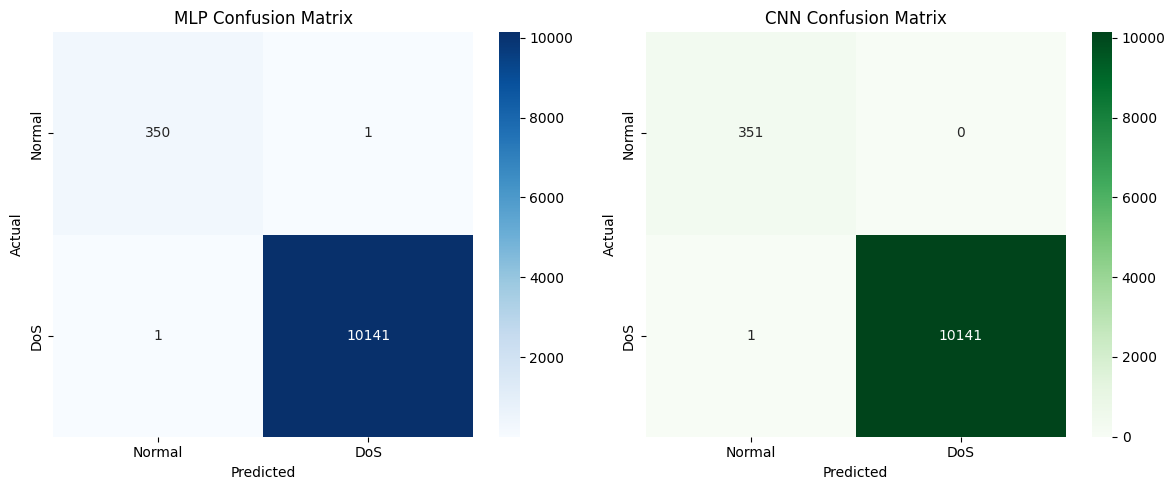

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrices
mlp_cm = confusion_matrix(y_test, mlp_y_pred)
cnn_cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix for MLP
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(mlp_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "DoS"], yticklabels=["Normal", "DoS"])
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Visualize confusion matrix for CNN
plt.subplot(1, 2, 2)
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Normal", "DoS"], yticklabels=["Normal", "DoS"])
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()


# New Section

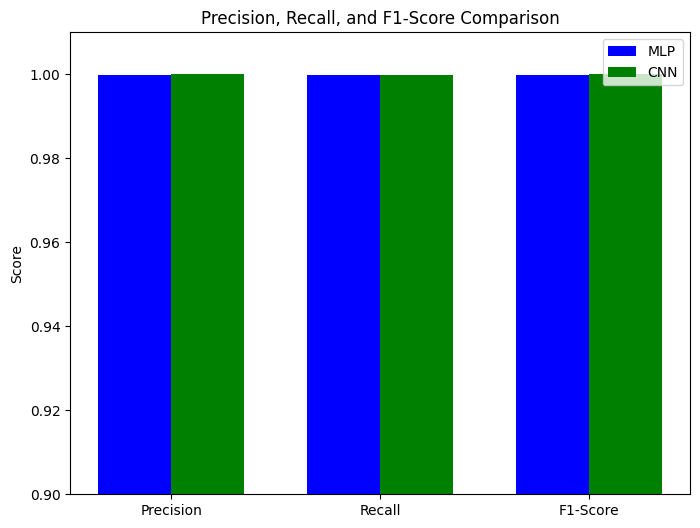

In [ ]:

from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate metrics for MLP
mlp_precision = precision_score(y_test, mlp_y_pred)
mlp_recall = recall_score(y_test, mlp_y_pred)
mlp_f1 = f1_score(y_test, mlp_y_pred)

# Calculate metrics for CNN
cnn_precision = precision_score(y_test, y_pred)
cnn_recall = recall_score(y_test, y_pred)
cnn_f1 = f1_score(y_test, y_pred)

# Data for plotting
metrics = ["Precision", "Recall", "F1-Score"]
mlp_scores = [mlp_precision, mlp_recall, mlp_f1]
cnn_scores = [cnn_precision, cnn_recall, cnn_f1]

# Create bar plots
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, mlp_scores, width, label="MLP", color="blue")
plt.bar(x + width/2, cnn_scores, width, label="CNN", color="green")

plt.xticks(x, metrics)
plt.ylim(0.9, 1.01)  # Adjust range for better visibility
plt.title("Precision, Recall, and F1-Score Comparison")
plt.ylabel("Score")
plt.legend()
plt.show()

In [ ]:

mlp_model.save("dos_detection_mlp.keras")